# DCGAN

In [1]:
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
import keras.backend as K
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)


In [0]:
X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)
X_test = X_test.reshape(-1, 28, 28, 1).astype(np.float32)

In [0]:
X_train /= 255.; X_test /= 255.

In [0]:
n = len(X_train)

## Training procedure

Create random data for the generator

In [0]:
def noise(batch_size): return np.random.rand(batch_size, 100)

Create a batch of data for the discriminator, some real and some fake

In [0]:
def data_D(batch_size, G):
    half_batch = batch_size//2
    real_imgs = X_train[np.random.randint(0, n, size=half_batch)]
    X = np.concatenate((real_imgs, G.predict(noise(half_batch))))
    return X, [0]*half_batch + [1]*half_batch

Lock or release weights on a network

In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

In [0]:
def train(D, G, m, num_epochs=5000, batch_size=128):
    dl, gl = [],[]
    for e in tqdm(range(num_epochs)):
        X,y = data_D(batch_size, G)
        dl.append(D.train_on_batch(X,y))
        make_trainable(D, False)
        gl.append(m.train_on_batch(noise(batch_size), np.zeros([batch_size])))
        make_trainable(D, True)
    return dl,gl

## DCGAN Model

In [10]:
CNN_G = Sequential([
        Dense(128*7*7, input_dim=100),
        LeakyReLU(0.2),
        Reshape((7, 7, 128)),
        UpSampling2D(),
        Conv2D(64, (5, 5), padding='same'),
        LeakyReLU(0.2),
        UpSampling2D(),
        Conv2D(1, (5, 5), padding='same', activation='sigmoid')
])

In [11]:
CNN_D = Sequential([
        Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=(28,28,1)),
        LeakyReLU(0.2),
        Conv2D(128, (5, 5), strides=(2,2), padding='same'),
        LeakyReLU(0.2),
        Flatten(),
        Dense(256),
        LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
])

CNN_D.compile(Adam(1e-3), "binary_crossentropy")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train the discriminator a little so it can at elast tell a real image from random noise

In [12]:
sz = len(X_train)//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, epochs=1, verbose=2)









Epoch 1/1
 - 0s - loss: 0.3113


In [0]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [0]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

Now we can train D & G iteratively

In [15]:
dl, gl = train(CNN_D, CNN_G, CNN_m, 2500) 

  0%|          | 0/2500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/2500 [00:00<41:35,  1.00it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 2500/2500 [00:51<00:00, 49.60it/s]


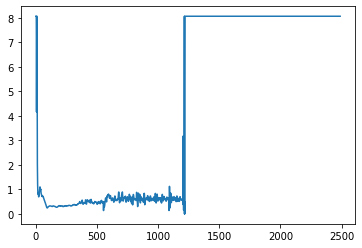

In [16]:
plt.plot(dl[10:])

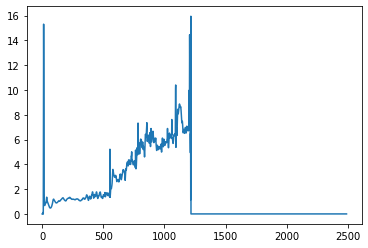

In [17]:
plt.plot(gl[10:])

In [0]:
generated = CNN_G.predict(noise(20)).reshape(20, 28,28)

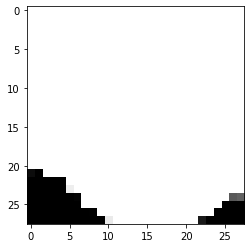

In [19]:
plt.imshow(generated[10], cmap='gray')